<a href="https://colab.research.google.com/github/vzinkovski/financial-data-science/blob/main/mean_reversion_pairs_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Commodities Mean Reversion Trading Strategy

In its most simple form, all trading strategies can be classified as either momentum or mean reversion. Commodities are often fungible which means they can be used as substitutes for each other given the right economics. For such fungible commodity pairs this implies both a positive correlation, as well as cointegration. Cointegration simply means that the individual price series for two commodities cannot deviate indefinitely and will revert to some mean value. This project will explore a mean reverting pairs trading strategy for a select universe of cointegrated commodity pairs. An inherent advantage of restricting our universe to commodities only is that these will be naturally free from survivorship bias.

### Import libraries

In [1]:
# standard libraries
from datetime import datetime, timedelta
import numpy as np
import pandas as pd

# financial analysis
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS
from statsmodels.tsa.stattools import adfuller
import yfinance as yf #Yahoo! Finance API

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

### USER INPUT: date range, trading pair, benchmark, risk free rate, hyperparameters

There are arguments against adding a stop loss in a mean reverting strategy. Instead, there should be opportunity to scale in further if one believes that the pair should mean revert. However, as the saying goes, markets can stay irrational longer than one can stay solvent.

In [2]:
# date range
start = '2012-01-01' # YYYY-MM-DD format
end = datetime.now() - timedelta(1) # dynamically get yday's date
# end = '2021-01-01' # YYYY-MM-DD format

# trading pair
product1_name = 'CME SRW' # Soft Red Winter Wheat
product1_ticker = 'ZW=F'
product2_name = 'CME HRW' # Kansas Hard Red Winter Wheat
product2_ticker = 'KE=F'

# product1_name = 'Brent' # Soft Red Winter Wheat
# product1_ticker = 'BZ=F'
# product2_name = 'WTI' # Kansas Hard Red Winter Wheat
# product2_ticker = 'CL=F'

# benchmark
benchmark_name = 'S&P GSCI' # S&P GSCI
benchmark_ticker = 'GD=F'

# risk free rate
rfr_name = '3M US T-Bill' # 3-month US Treasury Bills
rfr_ticker = '^IRX'

# hyperparameters
lookback = 30 # rolling window for calculating mean and standard deviation
entry_threshold = 2 # Bollinger Bands +/- standard deviation width
exit_threshold = 0 # generate exit signal when mean reverting
stop_loss = 10 # generate exit signal when excessively mean diverting
alpha = 0.05 # threshold for Augmented Dicky Fuller (ADF) stationarity test
fees = 0.015 # fees, commissions, slippage, market impact as a % of each transaction

### Fetch ticker data

In [3]:
def create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start, end):

  # fetch closing prices for commodities pair
  pairs_df = yf.download([product1_ticker, product2_ticker], start=start, end=end)['Adj Close']
  pairs_df.rename(columns={product1_ticker:product1_name, product2_ticker:product2_name}, inplace=True)
  pairs_df.fillna(method='ffill', inplace=True)

  return pairs_df

### Calculate spread

In [4]:
def calculate_spread(pairs_df, lookback):

  # pairs_df['spread'] = pairs_df.iloc[:,0] / pairs_df.iloc[:,1]
  # adf_ratio_spread = adfuller(pairs_df['spread'])
  # return pairs_df, adf_ratio_spread

  # fit a rolling linear regression between the commodities pair
  model = RollingOLS(endog=pairs_df.iloc[:,0],
                     exog=sm.add_constant(pairs_df.iloc[:,1]),
                     window=lookback)
  rolling_res = model.fit()
  params = rolling_res.params.copy()

  # calculate the hedge ratio
  pairs_df['hedge_ratio'] = params.iloc[:,1]
  pairs_df.dropna(inplace=True)

  # method 1: calculate the hedge ratio spread and ADF test statistic
  pairs_df['hedge_ratio_spread'] = pairs_df.iloc[:,0] - pairs_df['hedge_ratio'] * pairs_df.iloc[:,1]
  adf_hedge_ratio_spread = adfuller(pairs_df['hedge_ratio_spread'])

  # method 2: calculate the ratio spread and ADF test statistic
  pairs_df['ratio_spread'] = pairs_df.iloc[:,0] / pairs_df.iloc[:,1]
  adf_ratio_spread = adfuller(pairs_df['ratio_spread'])

  # choose spread with more negative ADF test statistic and append to dataframe
  if adf_hedge_ratio_spread[0] < adf_ratio_spread[0]:
    pairs_df['spread'] = pairs_df['hedge_ratio_spread']
    pairs_df.drop('hedge_ratio_spread', axis=1, inplace=True)
    return pairs_df, adf_hedge_ratio_spread
  else:
    pairs_df['spread'] = pairs_df['ratio_spread']
    pairs_df.drop(columns=['ratio_spread', 'hedge_ratio'], axis=1, inplace=True)
    return pairs_df, adf_ratio_spread

### Test for stationarity

In order to implement a mean reverting strategy we first have to ensure our data is stationary, which simply means a constant mean and variance. A simple test is a quick visual inspection, however a more robust statistical test is the Augmented Dicky-Fuller (ADF) test. A typical $a$ is 0.05 and we reject the null hypothesis when our p-value is below this threshold. In other words, if our p-value is less than $a$ we may conclude that our data is indeed stationary.

In [5]:
def test_stationarity(pairs_df, adf_result, alpha):
    
    # perform ADF test to check for stationarity
    if adf_result[1] < alpha:
      return (pairs_df, adf_result, True)
    else:
      return (pairs_df, adf_result, False)

In [6]:
# run functions
pairs_df = create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start, end)
pairs_df, adf_result = calculate_spread(pairs_df, lookback)
pairs_df, adf_result, check = test_stationarity(pairs_df, adf_result, alpha)

[*********************100%***********************]  2 of 2 completed


In [7]:
# print ADF test statistics
print('ADF statistic:\n%f' % adf_result[0], '\n')
print('p-value: \n%f' % adf_result[1], '\n')
print('Critical values:')
for key, value in adf_result[4].items():
  print('%s @ %.3f' % (key, value))

ADF statistic:
-7.753039 

p-value: 
0.000000 

Critical values:
1% @ -3.433
5% @ -2.863
10% @ -2.567


### Calculate Bollinger Bands

In [8]:
def calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss):

  # calculate the rolling mean and rolling std
  pairs_df['mean'] = pairs_df['spread'].rolling(window=lookback).mean()
  pairs_df['std'] = pairs_df['spread'].rolling(window=lookback).std()

  # calculate the rolling entry and exit bands, and rolling stop loss bands
  pairs_df['upper_entry'] = pairs_df['mean'] + entry_threshold * pairs_df['std']
  pairs_df['lower_entry'] = pairs_df['mean'] - entry_threshold * pairs_df['std']
  pairs_df['upper_exit'] = pairs_df['mean'] + exit_threshold * pairs_df['std']
  pairs_df['lower_exit'] = pairs_df['mean'] - exit_threshold * pairs_df['std']
  pairs_df['upper_stop_loss'] = pairs_df['mean'] + stop_loss * pairs_df['std']
  pairs_df['lower_stop_loss'] = pairs_df['mean'] - stop_loss * pairs_df['std']

  return pairs_df

### Define trading rules and get signal

Our base strategy is essentially a Bollinger Bands strategy, which means only a few adjustable hyperparameters, namely the lookback window and standard deviation. Another potential adjustment is whether to use a SMA or EWMA, which we will leave as a future exercise.

In [9]:
def get_trading_signals(pairs_df):

  # create signal column {-1, 0, 1}
  pairs_df['signal'] = 0

  # iterating through the time series to determine whether to buy/hold/sell
  # cannot be vectorised as today's trading signal depends on yday's signal
  # as such time complexity will be linear O(N)
  for i in range(1, len(pairs_df)):

    # from hold to sell or buy
    if pairs_df.iloc[i-1, -1] == 0:
      if (pairs_df['spread'][i] < pairs_df['upper_entry'][i]) & \
         (pairs_df['spread'][i-1] >= pairs_df['upper_entry'][i-1]):
        pairs_df.iloc[i, -1] = -1
      elif (pairs_df['spread'][i] > pairs_df['lower_entry'][i]) & \
           (pairs_df['spread'][i-1] <= pairs_df['lower_entry'][i-1]):
        pairs_df.iloc[i, -1] = 1

    # from sell to hold
    elif pairs_df.iloc[i-1, -1] == -1:
      if (pairs_df['spread'][i] < pairs_df['upper_exit'][i]) & \
         (pairs_df['spread'][i-1] >= pairs_df['upper_exit'][i-1]):
        pairs_df.iloc[i, -1] = 0
      # trigger stop loss on excessive mean diversion to the upside
      elif (pairs_df['spread'][i] > pairs_df['upper_stop_loss'][i]) & \
           (pairs_df['spread'][i-1] <= pairs_df['upper_stop_loss'][i-1]):
        pairs_df.iloc[i, -1] = 0
      else:
        pairs_df.iloc[i, -1] = -1

    # from sell to hold
    elif pairs_df.iloc[i-1, -1] == 1:
      if (pairs_df['spread'][i] > pairs_df['lower_exit'][i]) & \
         (pairs_df['spread'][i-1] <= pairs_df['lower_exit'][i-1]):
        pairs_df.iloc[i, -1] = 0
      # trigger stop loss on excessive mean diversion to the downside
      elif (pairs_df['spread'][i] < pairs_df['lower_stop_loss'][i]) & \
           (pairs_df['spread'][i-1] >= pairs_df['lower_stop_loss'][i-1]):
        pairs_df.iloc[i, -1] = 0
      else:
        pairs_df.iloc[i, -1] = 1

  return pairs_df

In [10]:
# run functions
pairs_df = calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss)
pairs_df = get_trading_signals(pairs_df)

### Plot Bollinger Bands and signal

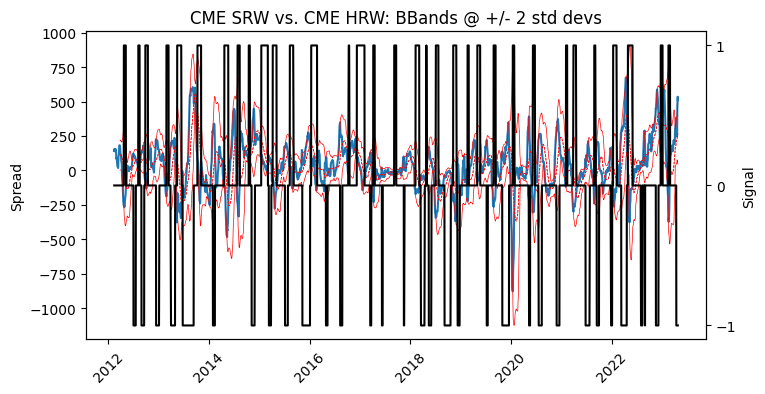

In [11]:
# plot bollinger bands & signal
fig, ax1 = plt.subplots(figsize=(8, 4))
ax2 = ax1.twinx()

ax1.plot(pairs_df.index, pairs_df['spread'])
ax1.plot(pairs_df.index, pairs_df['upper_entry'], color='r', linewidth=0.5, label='upper_entry')
ax1.plot(pairs_df.index, pairs_df['lower_entry'], color='r', linewidth=0.5, label='lower_entry')
ax1.plot(pairs_df.index, pairs_df['upper_exit'], color='r', linewidth=0.5, linestyle='--', label='upper_exit')
ax1.plot(pairs_df.index, pairs_df['lower_exit'], color='r', linewidth=0.5, linestyle='--', label='lower_exit')
ax1.set_ylabel('Spread')
ax1.tick_params(axis='x', rotation=45)

ax2.plot(pairs_df.index, pairs_df['signal'], color='k')
ax2.set_ylabel('Signal')
ax2.set_yticks([-1,0,1])

plt.title(f'{product1_name} vs. {product2_name}: BBands @ +/- {entry_threshold} std devs')
# ax1.legend()
plt.show();

In [12]:
# pairs_df['2020-04-01':'2020-05-01']

### Get equity curve

In [13]:
def get_equity_curve(pairs_df, product1_name, product2_name, fees):

  pairs_df[f'{product1_name}_returns'] = pairs_df[product1_name].pct_change()
  pairs_df[f'{product2_name}_returns'] = pairs_df[product2_name].pct_change()
  pairs_df['pair_daily_returns'] = pairs_df['signal'].shift() * (1-fees) * (pairs_df[f'{product1_name}_returns'] - pairs_df[f'{product2_name}_returns'])
  pairs_df['pair_cumulative_returns'] = (1 + pairs_df['pair_daily_returns']).cumprod()

  return pairs_df

### Plot equity curve

In [14]:
# run functions
pairs_df = get_equity_curve(pairs_df, product1_name, product2_name, fees)

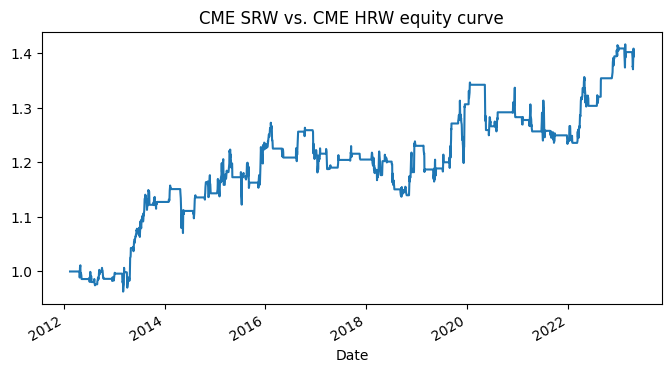

In [15]:
# plot equity curve
plt.subplots(figsize=(8, 4))
plt.title(f'{product1_name} vs. {product2_name} equity curve')
pairs_df['pair_cumulative_returns'].plot();

### USER INPUT: Commodities pairs universe

In [16]:
pairs_universe = [
            
  # AGRICULTURE

            # corn srw
            {'product1_name':'corn', 
             'product1_ticker':'ZC=F',
             'product2_name':'srw',
             'product2_ticker':'ZW=F'
             },

            # corn hrw
            {'product1_name':'corn', 
             'product1_ticker':'ZC=F',
             'product2_name':'hrw',
             'product2_ticker':'KC=F'
             },

            # srw hrw
            {'product1_name':'srw', 
             'product1_ticker':'ZW=F',
             'product2_name':'hrw',
             'product2_ticker':'KE=F'
             },

            # soybeans soymeal
            {'product1_name':'soybean', 
             'product1_ticker':'ZS=F',
             'product2_name':'soymeal',
             'product2_ticker':'ZM=F'
             },

            # soybeans soyoil
            {'product1_name':'soybean', 
             'product1_ticker':'ZS=F',
             'product2_name':'soyoil',
             'product2_ticker':'ZL=F'
             },

            # soymeal soyoil
            {'product1_name':'soymeal', 
             'product1_ticker':'ZM=F',
             'product2_name':'soyoil',
             'product2_ticker':'ZL=F'
             },

  # METALS

            # gold silver
            {'product1_name':'gold',
             'product1_ticker':'GC=F',
             'product2_name':'silver',
             'product2_ticker':'SI=F'
             },

            # gold platinum
            {'product1_name':'gold', 
             'product1_ticker':'GC=F',
             'product2_name':'platinum',
             'product2_ticker':'PL=F'
             },

            # silver platinum
            {'product1_name':'silver', 
             'product1_ticker':'SI=F',
             'product2_name':'platinum',
             'product2_ticker':'PL=F'
             },

#   # ENERGY

#             # brent wti
#             {'product1_name':'brent', 
#              'product1_ticker':'BZ=F',
#              'product2_name':'wti',
#              'product2_ticker':'CL=F'
#              },

]

### Get portfolio returns

In [17]:
def get_portfolio_returns(pairs_universe):

  # create empty list of dataframes
  dfs = []
  columns = []

  # loop through all pairs in universe
  for pair in pairs_universe:

    # convenience variables
    product1_name = pair['product1_name']
    product1_ticker = pair['product1_ticker']
    product2_name = pair['product2_name']
    product2_ticker = pair['product2_ticker']

    # run functions
    pairs_df = create_pairs_df(product1_name, product1_ticker, product2_name, product2_ticker, start, end)
    pairs_df, adf_result = calculate_spread(pairs_df, lookback)
    pairs_df, adf_result, check = test_stationarity(pairs_df, adf_result, alpha)

    # proceed only for stationary time series
    if check:

      # run functions
      pairs_df = calculate_bbands(pairs_df, lookback, entry_threshold, exit_threshold, stop_loss)
      pairs_df = get_trading_signals(pairs_df)
      pairs_df = get_equity_curve(pairs_df, product1_name, product2_name, fees)

      # append returns for each pair to dataframe
      pairs_df['pair_cumulative_returns'].fillna(method='ffill', inplace=True)
      dfs.append(pairs_df['pair_cumulative_returns'])
      columns.append(f'{product1_name}_{product2_name}')

  # create dataframe from list and calculate mean returns
  pairs_universe_df = pd.DataFrame(dfs).T
  pairs_universe_df.columns = columns
  pairs_universe_df['portfolio_cumulative_returns'] = pairs_universe_df.mean(axis=1)

  return pairs_universe_df

In [18]:
# get portfolio returns
pairs_universe_df = get_portfolio_returns(pairs_universe)

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


### Get benchmark returns

In [19]:
# get benchmark returns
bm_df = yf.download([benchmark_ticker], start=start, end=end)
bm_df.fillna(method='ffill', inplace=True)
bm_df[f'{benchmark_name}_daily_returns'] = bm_df['Adj Close'].pct_change()
bm_df[f'{benchmark_name}_cumulative_returns'] = (1 + bm_df[f'{benchmark_name}_daily_returns']).cumprod()

[*********************100%***********************]  1 of 1 completed


### Plot portfolio and benchmark returns

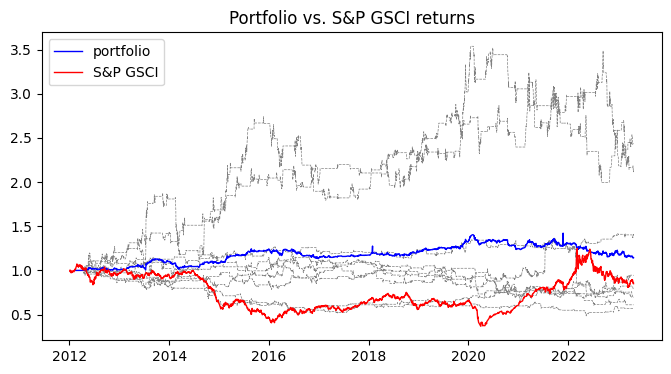

In [20]:
# plot portfolio and benchmark returns
plt.subplots(figsize=(8, 4))

for col in pairs_universe_df.columns[:-1]:
  plt.plot(pairs_universe_df.index, pairs_universe_df[col], color='gray', linewidth=0.5, linestyle='--')

plt.plot(pairs_universe_df.index, pairs_universe_df['portfolio_cumulative_returns'], color='b', linewidth=1, label='portfolio')
plt.plot(bm_df.index, bm_df[f'{benchmark_name}_cumulative_returns'], color='r', linewidth=1, label=f'{benchmark_name}')
plt.title(f'Portfolio vs. {benchmark_name} returns')
plt.legend()
plt.show();

### Performance metrics

In [21]:
# get risk free rate
rfr_df = yf.download([rfr_ticker], start=start, end=end)
rfr_df['daily_risk_free_rate'] = rfr_df['Adj Close'] / 100 / 252
rfr_df.fillna(method='ffill', inplace=True)

[*********************100%***********************]  1 of 1 completed


In [22]:
# calculate returns in excess of risk free rate
pairs_universe_df['portfolio_daily_returns'] = pairs_universe_df['portfolio_cumulative_returns'].diff().shift(-1)
pairs_universe_df['daily_risk_free_rate'] = rfr_df['daily_risk_free_rate']
pairs_universe_df['excess_returns'] = pairs_universe_df['portfolio_daily_returns'] - pairs_universe_df['daily_risk_free_rate']
pairs_universe_df.dropna(inplace=True)

In [26]:
# calculate sharpe ratio
sharpe_ratio = pairs_universe_df['excess_returns'].mean() / pairs_universe_df['excess_returns'].std()
sharpe_ratio_annualised = sharpe_ratio * np.sqrt(252)

# calculate sortino ratio
downside_returns = pairs_universe_df['excess_returns'][pairs_universe_df['excess_returns'] < 0]
downside_deviation = downside_returns.std()
sortino_ratio = pairs_universe_df['excess_returns'].mean() / downside_deviation
sortino_ratio_annualised = sortino_ratio * np.sqrt(252)

# calculate max drawdown % from peak to trough
rolling_max = pairs_universe_df['portfolio_cumulative_returns'].expanding().max()
drawdown = pairs_universe_df['portfolio_cumulative_returns'] - rolling_max
max_drawdown = (drawdown / rolling_max).min() * 100

# calulate portolfio alpha and beta vs. benchmark
temp_df = pd.concat([pairs_universe_df['portfolio_daily_returns'], bm_df[f'{benchmark_name}_daily_returns']], axis=1).dropna()
X = sm.add_constant(temp_df.iloc[:,1])
model = sm.OLS(temp_df.iloc[:,0], X).fit()
portfolio_alpha, portfolio_beta = model.params

# print performance metrics
print(f'Sharpe Ratio: \t\t {round(sharpe_ratio_annualised, 2)}')
print(f'Sortino Ratio: \t\t {round(sortino_ratio_annualised, 2)}')
print(f'Maximum drawdown: \t {round(max_drawdown, 2)}%')
print(f'Alpha vs. {benchmark_name}: \t {round(portfolio_alpha, 4)}')
print(f'Beta vs. {benchmark_name}: \t {round(portfolio_beta, 4)}')

Sharpe Ratio: 		 0.26
Sortino Ratio: 		 0.4
Maximum drawdown: 	 -18.73%
Alpha vs. S&P GSCI: 	 0.0001
Beta vs. S&P GSCI: 	 -0.003


### Concluding remarks and further investigation

Although our portfolio equity curve does indeed outperform the benchmark, this does not show the full picture. Unfortunately, when taking into account the risk free rate and volatility, our risk-adjusted returns show a poor score for both the Sharpe and Sortino ratios. As reference, a Sharpe ratio of between 1-2% is satisfactory, and above 2% is considered as good.

There is still much room for improvement. To be continued...

# END

*Author: Vladimir Zinkovski*